In [2]:
import tensorflow as tf

In [6]:
train=r"/home/teaching/Atmega_MIC/DP Students/Abhay/cropwise_data/strawberry"
training_set = tf.keras.utils.image_dataset_from_directory(
    train,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 12500 files belonging to 3 classes.


In [7]:
classes = training_set.class_names
classes

['strawberry_calciumdeficiency',
 'strawberry_healthy',
 'strawberry_leaf_scorch']

In [8]:
total_batches = tf.data.experimental.cardinality(training_set).numpy()
train_size = int(0.8 * total_batches)
val_size = total_batches - train_size
train_dataset = training_set.take(train_size)
val_dataset = training_set.skip(train_size)
print(len(training_set))
print(len(train_dataset))
print(len(val_dataset))

196
156
40


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 6 classes
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


In [10]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import Sequential

preprocessing = Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1)
])

train_ds = train_dataset.map(lambda x, y: (preprocessing(x), y))
val_ds = val_dataset.map(lambda x, y: (x / 255.0, y))


In [11]:
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.4, patience=3, min_lr=1e-6)
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    callbacks=[early_stop, reduce_lr])


Epoch 1/10


2025-05-02 17:18:18.231569: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.
2025-05-02 17:18:18.250640: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.


  1/156 [..............................] - ETA: 13:01 - loss: 1.1117 - categorical_accuracy: 0.4531

2025-05-02 17:18:18.824172: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.
2025-05-02 17:18:18.851843: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 313810944 exceeds 10% of free system memory.


  2/156 [..............................] - ETA: 2:05 - loss: 0.8508 - categorical_accuracy: 0.6562 

2025-05-02 17:18:19.688555: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 308281344 exceeds 10% of free system memory.


156/156 [==============================] - 153s 956ms/step - loss: 0.0501 - categorical_accuracy: 0.9828 - val_loss: 0.0205 - val_categorical_accuracy: 0.9928 - lr: 0.0010
Epoch 2/10
156/156 [==============================] - 136s 864ms/step - loss: 0.0117 - categorical_accuracy: 0.9970 - val_loss: 0.1004 - val_categorical_accuracy: 0.9674 - lr: 0.0010
Epoch 3/10
156/156 [==============================] - 137s 871ms/step - loss: 0.0071 - categorical_accuracy: 0.9977 - val_loss: 0.0096 - val_categorical_accuracy: 0.9972 - lr: 0.0010
Epoch 4/10
156/156 [==============================] - 138s 874ms/step - loss: 0.0094 - categorical_accuracy: 0.9966 - val_loss: 0.0117 - val_categorical_accuracy: 0.9964 - lr: 0.0010
Epoch 5/10
156/156 [==============================] - 136s 858ms/step - loss: 0.0021 - categorical_accuracy: 0.9997 - val_loss: 0.0084 - val_categorical_accuracy: 0.9960 - lr: 0.0010
Epoch 6/10
156/156 [==============================] - 127s 799ms/step - loss: 0.0016 - categoric

In [12]:
train_loss,train_acc = model.evaluate(train_ds)

156/156 [==============================] - 96s 601ms/step - loss: 3.9852e-04 - categorical_accuracy: 1.0000


In [13]:
model.save("trained_models/trained_model_strawberry.keras")

In [14]:
train_loss, train_acc

(0.0003985201474279165, 1.0)

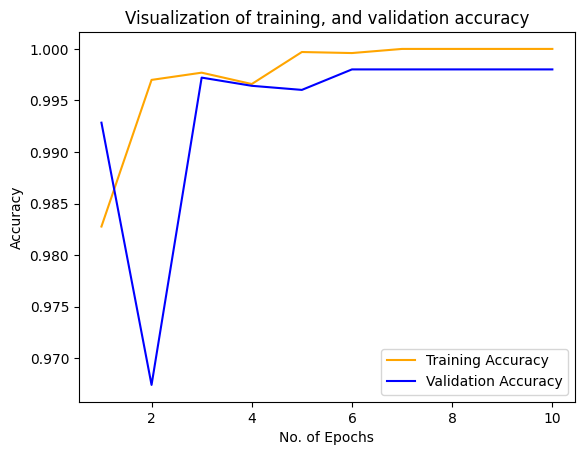

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

epochs=[i for i in range(1,11)]
plt.plot(epochs,history.history['categorical_accuracy'],color='orange',label='Training Accuracy')
plt.plot(epochs,history.history['val_categorical_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Visualization of training, and validation accuracy')
plt.legend()
plt.show()
